# Introduction

This script takes the netcdf output of a PARCELS simulation and carries out posthoc analyses on the particle positions and other variables at the time of their termination/end of their Larval Dispersal Duration (LDD). The details of this simulation are in a different notebook



In [1]:
import networkx as nx
import numpy as np
import matplotlib as mpl 
import xarray as xr
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.cm as cm 
from random import randrange
import seaborn as sns
import math as math
import adjustText
import adjustText
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
import seaborn as sns


# Import data
This script was initially designed to work with the output of many different dispersal scenarios and I have kept some of these parameters in the script to demonstrate this. However, here we just focus on a simulation of 3D dispersal starting at 100m altitude above each vent site

In [2]:
run = "final"
#run = "3d"
#run = "tst3d"
#run="tstdepth"

In [3]:
zgr = xr.open_dataset('data/glorys12v1_p_zgr.nc')
hgr = xr.open_dataset('data/glorys12v1_p_hgr.nc')

In [4]:
depths = ['10m','100m','200m','300m','400m','500m','600m','700m','800m','900m','1000m']
depth = depths[1]
vent_sites=pd.read_csv('data/lau_vent_sites.csv',index_col = 'vent_field')

vent_sites['name']=vent_sites.index.str.replace(" ", "_")
v_name=vent_sites.name[0]
vent_sites

,lat,lon,depth,name
vent_field,,,,
Mangatolo,-15.416017,-174.655517,2039,Mangatolo
Tahi Moana,-20.690000,-176.180000,2256,Tahi_Moana
ABE,-20.763050,-176.191300,2153,ABE
Tui Malila,-21.989133,-176.568317,1886,Tui_Malila
Tow Cam,-20.320000,-176.140000,2700,Tow_Cam
Kilo Moana,-20.050000,-176.130000,2620,Kilo_Moana
Fatu Kapa,-14.750000,-177.150000,1500,Fatu_Kapa


In [5]:
ptcls = xr.open_dataset('output/particles/'+run+'_'+depth+'_alt'+v_name+'.nc')
ptcls

<xarray.Dataset>
Dimensions:     (traj: 874341, obs: 1)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    age         (traj, obs) float32 ...
    maturity    (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
    avtemp      (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.2.dev51
    parcels_mesh:           spherical

In [6]:
ptcls['avtemp']

<xarray.DataArray 'avtemp' (traj: 874341, obs: 1)>
[874341 values with dtype=float32]
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  avtemp
    units:          unknown

# Summary Stats

## Create a dataframe of all particle variables from all vents

In [7]:
df_all = pd.DataFrame(columns=["traj","obs","age","depth","date","date_r"])

for v in range(0,len(vent_sites)):
    vent_name=str(vent_sites.index[v])
    v_name = vent_name.replace(" ", "_")
    ptcls = xr.open_dataset('output/particles/'+run+'_'+depth+'_alt'+v_name+'.nc')
    ptcls= ptcls.dropna('traj')
    
    # Select data variables to convert to columns
    var1 = ptcls['age']
    var2 = ptcls['z']
    var3 = ptcls['time']


    # Convert to pandas DataFrame
    df = var1.to_dataframe(name='age').reset_index()
    df['depth'] = var2.values  # Add a new column
    df['date'] = var3.values 
    df['date'] = pd.to_datetime(df['date']) #Add date of termination
    #determine date of release from age and date at termination
    df['date_r'] = df['date'] -  pd.to_timedelta(df['age'], unit='s') 
    df['age'] = df['age']/86400 #transform age from seconds to days
    df['obs'] = v_name  # Add vent name

    df_all = df_all.append(df)
    

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/886624586.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df)
/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/886624586.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df)
/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/886624586.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df)
/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/886624586.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df)
/var/folders/5h/ggjcl6b11dvf

In [8]:
df_all

,traj,obs,age,depth,date,date_r
0,0,Mangatolo,104.708333,2294.086910,2010-04-12 18:00:00,2009-12-29 01:00:00
1,1,Mangatolo,104.375000,1946.090191,2010-04-12 10:00:00,2009-12-29 01:00:00
2,2,Mangatolo,103.916667,1779.727266,2010-04-11 23:00:00,2009-12-29 01:00:00
3,3,Mangatolo,104.083333,1800.745314,2010-04-12 03:00:00,2009-12-29 01:00:00
4,4,Mangatolo,104.583333,1939.219325,2010-04-12 15:00:00,2009-12-29 01:00:00
...,...,...,...,...,...,...
875995,875995,Fatu_Kapa,88.875000,1327.594586,2016-03-25 16:00:00,2015-12-27 19:00:00
875996,875996,Fatu_Kapa,90.791667,1375.656541,2016-03-27 14:00:00,2015-12-27 19:00:00
875997,875997,Fatu_Kapa,88.166667,1415.631255,2016-03-24 23:00:00,2015-12-27 19:00:00
875998,875998,Fatu_Kapa,90.791667,1389.452568,2016-03-27 14:00:00,2015-12-27 19:00:00


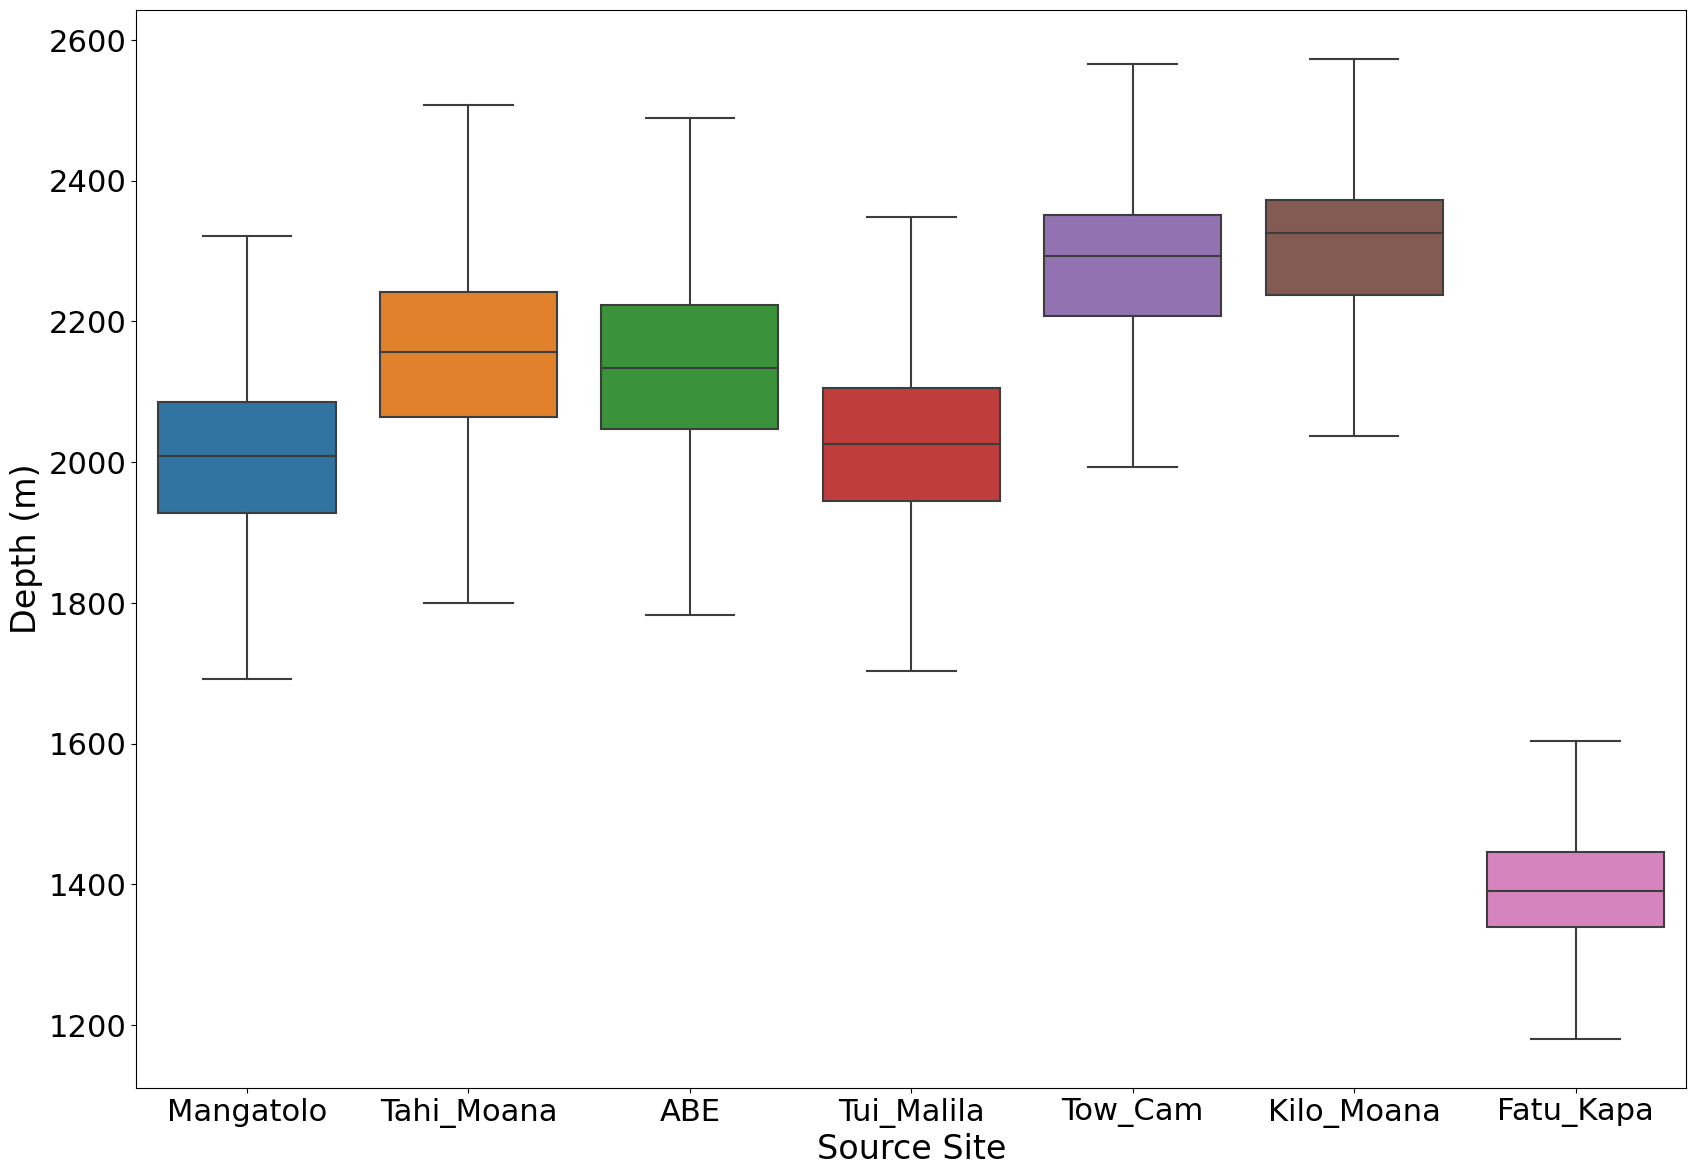

In [9]:
#tips = sns.load_dataset('df_yr')
fig, ax = plt.subplots(
    1, 1, figsize=(20, 14))
ax = sns.boxplot(x="obs", y="depth", data=df_all, showfliers = False)
ax.set_ylabel('Depth (m)',fontsize=24)
ax.set_xlabel('Source Site',fontsize=24)

ax.tick_params(axis='x',labelsize=22)
ax.tick_params(axis='y',labelsize=22)

plt.savefig('figures/box_depth.pdf')

plt.show()

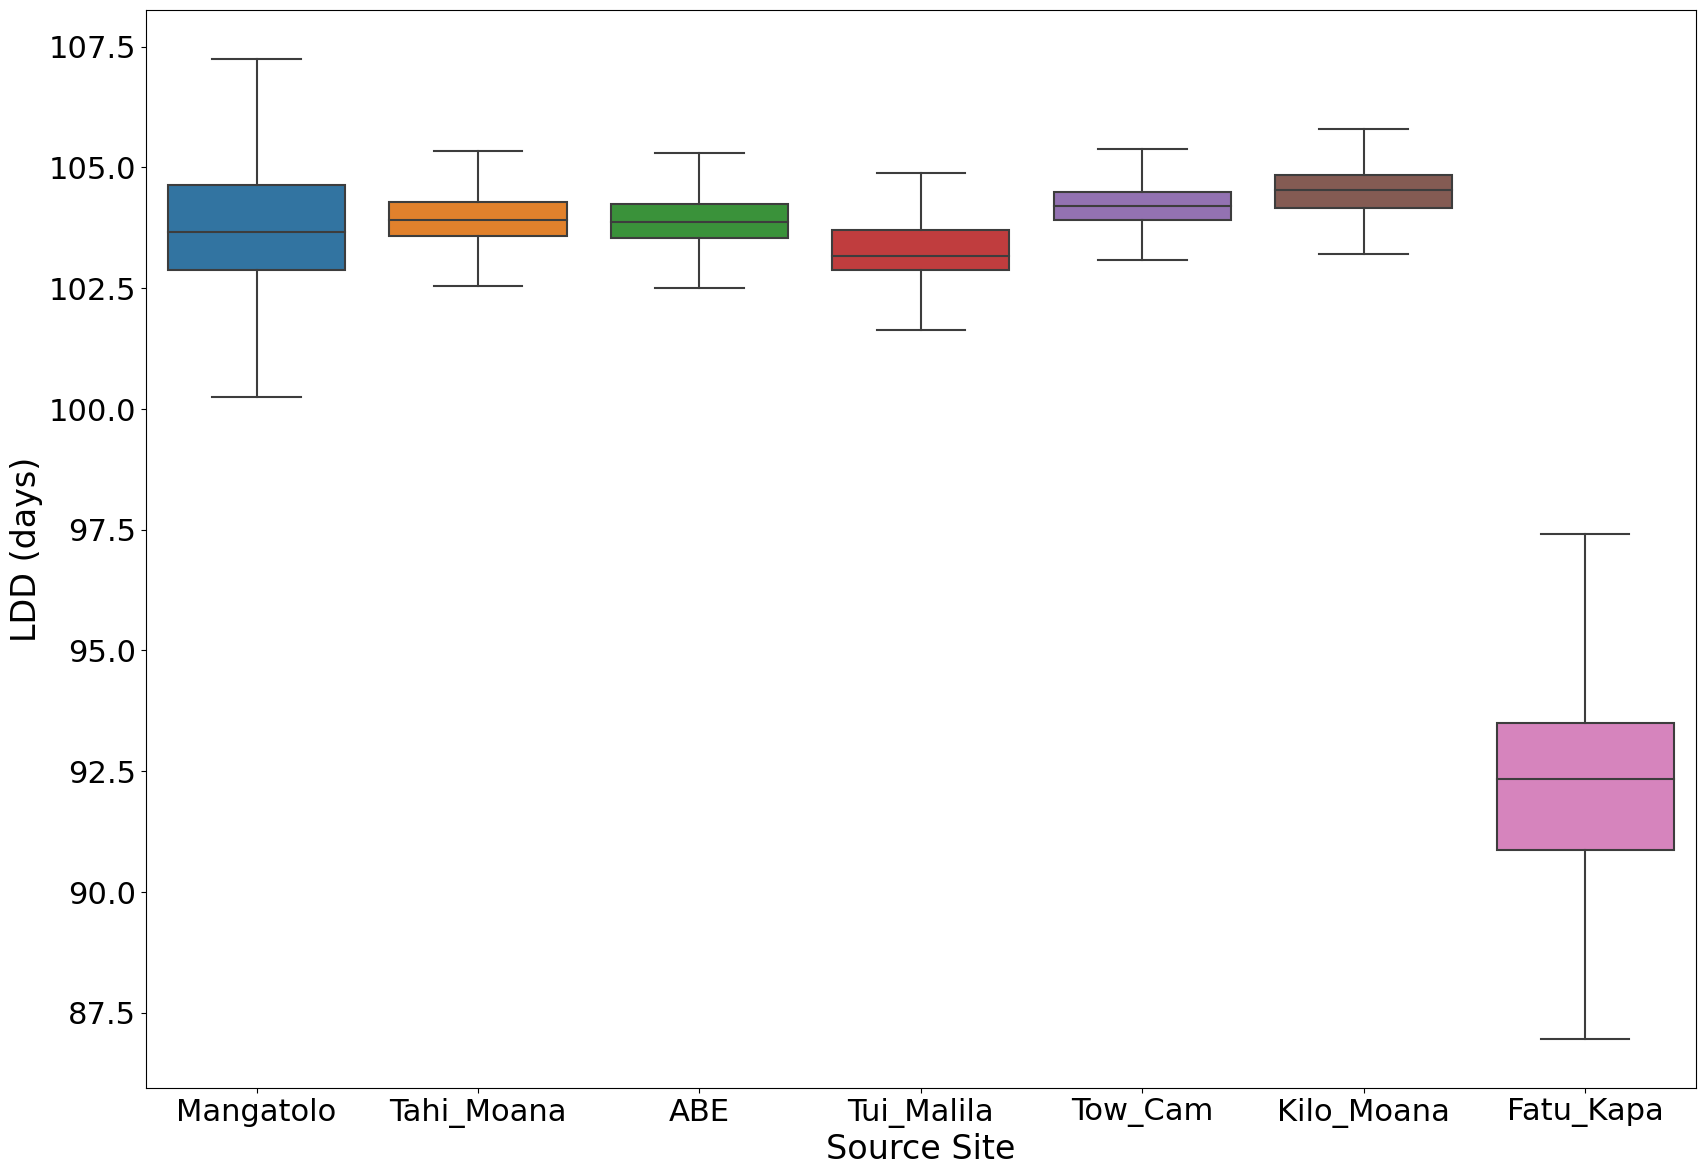

In [10]:
#tips = sns.load_dataset('df_yr')
fig, ax = plt.subplots(
    1, 1, figsize=(20, 14))
ax = sns.boxplot(x="obs", y="age", data=df_all,showfliers = False)
ax.set_ylabel('LDD (days)',fontsize=24)
ax.set_xlabel('Source Site',fontsize=24)

ax.tick_params(axis='x',labelsize=22)
ax.tick_params(axis='y',labelsize=22)
plt.savefig('figures/box_LDD.pdf')

plt.show()

## Integrate PDFS 

In [11]:
from scipy.spatial.distance import cdist
import numpy as np

# Define function to calculate Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000.0  # radius of the Earth in meters
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

# Define function to get probability density within a 100m x 100m box around a point
def get_prob_density_in_box(kde, point):
    lat, lon = point
    box_size = 100.0  # size of the box in meters
    lat_diff = box_size / haversine(lat, lon, lat + 1, lon)  # adjust box size based on latitude
    lon_diff = box_size / haversine(lat, lon, lat, lon + 1)  # adjust box size based on longitude
    box = [[lat - lat_diff/2, lon - lon_diff/2], [lat + lat_diff/2, lon + lon_diff/2]]  # define bounding box
    prob_density = kde.integrate_box(*box)  # calculate probability density within box
    return prob_density


/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/956585690.py:40: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


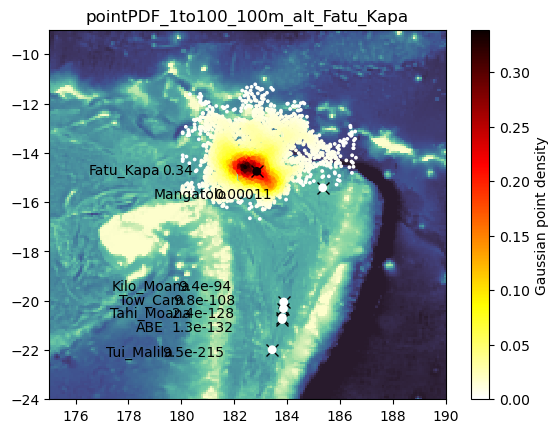

In [12]:
txtpos_x=vent_sites.lon-3
txtpos_y = [-15.7, -20.5, -21.1, -22.1, -20, -19.4, -14.7]
s=100

ptcls = xr.open_dataset('output/particles/'+run+'_'+depth+'_alt'+v_name+'.nc')

data_a=ptcls
lat_a = np.ma.filled(data_a.variables['lat'], np.nan)
lon_a = np.ma.filled(data_a.variables['lon'], np.nan)
x_a = lon_a[~np.isnan(lon_a)][0::s]
y_a = lat_a[~np.isnan(lat_a)][0::s]
xy_a = np.vstack([x_a,y_a])
z_a = gaussian_kde(xy_a)(xy_a)
xmin = x_a.min()
xmax = x_a.max()
ymin = y_a.min()
ymax = y_a.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
xy = np.vstack([x_a,y_a])
z = gaussian_kde(xy)(xy)
kde = gaussian_kde(xy_a)

points = np.vstack([vent_sites.lon,vent_sites.lat])
pdf= kde.evaluate(points)
Z = np.reshape(kde(positions).T, X.shape)
eg_pdf = pd.DataFrame({'Source':np.repeat(v_name,len(vent_sites.lon)),
                         'Target':vent_sites.name,
                         'lon':vent_sites.lon,
                         'lat':vent_sites.lat,
                         'weight': pdf})



fig, ax = plt.subplots()

#ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
ax.scatter(x_a%360, y_a, c=z, cmap=plt.cm.hot_r, s=3, zorder=2)

ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


ax.set_xlim(175, 190)
ax.set_ylim(-24, -9)
ax.plot(vent_sites['lon']%360, vent_sites['lat'], 
        'x',color="black", markersize=8)
scat=ax.scatter(eg_pdf.lon%360, eg_pdf.lat, c=eg_pdf.weight, cmap=plt.cm.hot_r, s=40,linewidths = 0,alpha=1, zorder=10)

# Annotate each point with its weight value
for i, txt in enumerate(eg_pdf.weight):
    ax.text(txtpos_x[i]%360, txtpos_y[i], f'{txt:.2g}', ha='center', va='center', color='black', fontsize=10)

# Annotate each point with its weight value
for i, txt in enumerate(eg_pdf.Target):
    ax.text(txtpos_x[i]%360-2, txtpos_y[i], f'{txt}', ha='center', va='center', color='black', fontsize=10)

    # Set title and colorbar
ax.set_title('pointPDF_1to'+str(s)+'_'+depth+'_alt_'+v_name+'')
cbar = fig.colorbar(scat)
cbar.set_label('Gaussian point density')


plt.show()

In [13]:
tst = vent_sites['lon'][-1], vent_sites['lat'][-1]
tst

(-177.15, -14.75)

In [14]:
intpdf = get_prob_density_in_box(kde, tst)
intpdf

2.7453733057981594e-07

## Plot PDFs

Here the particle files are subset by 's' because creating these plots with every single particle takes a long time. I then plot the position of each particle (at the end of their LDD) and colour them by the Probability Density Function (PDF) at this position. 

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


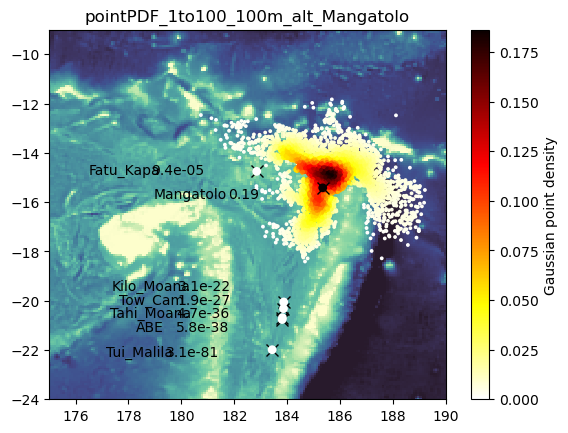

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


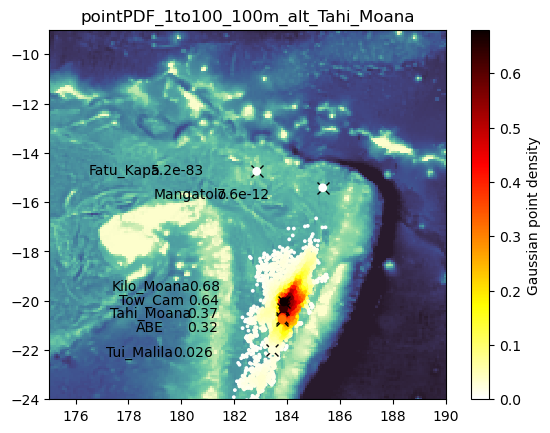

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


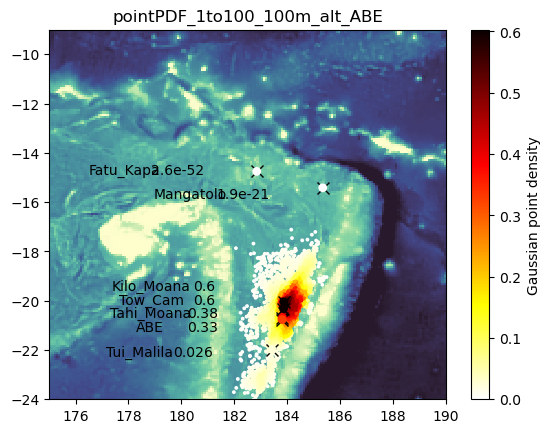

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


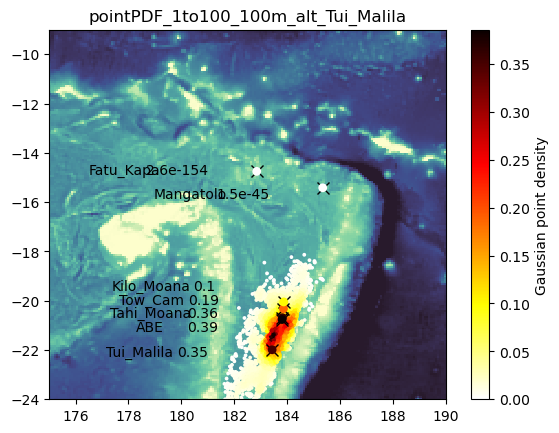

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


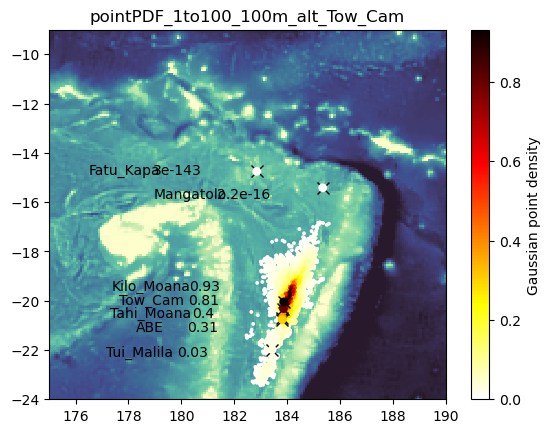

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


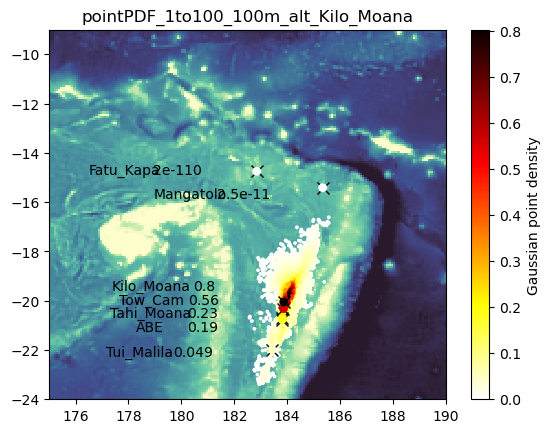

/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2616666368.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


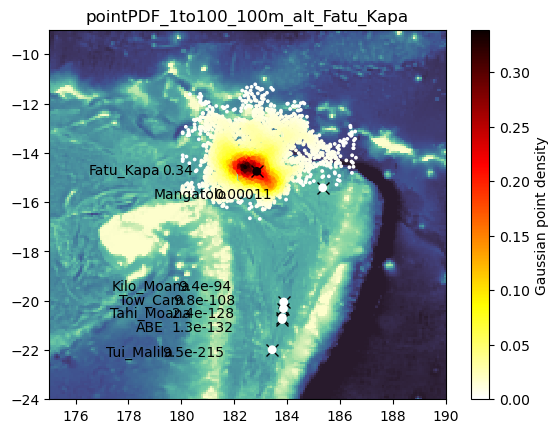

In [15]:
#LOOPIT
s=100
txtpos_x=vent_sites.lon-3
txtpos_y = [-15.7, -20.5, -21.1, -22.1, -20, -19.4, -14.7]


for v_name in vent_sites.name:
    ptcls = xr.open_dataset('output/particles/'+run+'_'+depth+'_alt'+v_name+'.nc')

    data_a=ptcls
    lat_a = np.ma.filled(data_a.variables['lat'], np.nan)
    lon_a = np.ma.filled(data_a.variables['lon'], np.nan)
    x_a = lon_a[~np.isnan(lon_a)][0::s]
    y_a = lat_a[~np.isnan(lat_a)][0::s]
    xy_a = np.vstack([x_a,y_a])
    z_a = gaussian_kde(xy_a)(xy_a)
    xmin = x_a.min()
    xmax = x_a.max()
    ymin = y_a.min()
    ymax = y_a.max()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    xy = np.vstack([x_a,y_a])
    z = gaussian_kde(xy)(xy)
    kde = gaussian_kde(xy_a)
    points = np.vstack([vent_sites.lon,vent_sites.lat])
    pdf= kde.evaluate(points)
    Z = np.reshape(kde(positions).T, X.shape)
    eg_pdf = pd.DataFrame({'Source':np.repeat(v_name,len(vent_sites.lon)),
                             'Target':vent_sites.name,
                             'lon':vent_sites.lon,
                             'lat':vent_sites.lat,
                             'weight': pdf})



    fig, ax = plt.subplots()

    #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
    ax.scatter(x_a%360, y_a, c=z, cmap=plt.cm.hot_r, s=3, zorder=2)

    ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0, zorder=1)


    ax.set_xlim(175, 190)
    ax.set_ylim(-24, -9)
    ax.plot(vent_sites['lon']%360, vent_sites['lat'], 
            'x',color="black", markersize=8)
    scat=ax.scatter(eg_pdf.lon%360, eg_pdf.lat, c=eg_pdf.weight, cmap=plt.cm.hot_r, s=40,linewidths = 0,alpha=1, zorder=10)

    # Annotate each point with its weight value
    for i, txt in enumerate(eg_pdf.weight):
        ax.text(txtpos_x[i]%360, txtpos_y[i], f'{txt:.2g}', ha='center', va='center', color='black', fontsize=10)

    # Annotate each point with its weight value
    for i, txt in enumerate(eg_pdf.Target):
        ax.text(txtpos_x[i]%360-2, txtpos_y[i], f'{txt}', ha='center', va='center', color='black', fontsize=10)

        # Set title and colorbar
    ax.set_title('pointPDF_1to'+str(s)+'_'+depth+'_alt_'+v_name+'')
    cbar = fig.colorbar(scat)
    cbar.set_label('Gaussian point density')

    plt.savefig('figures/pdfs/pointPDF_'+run+'_1to'+str(s)+'_'+depth+'_alt_'+v_name+'.png')

    plt.show()

# Create Network from PDFs

## Edgelist

Again I utilize a subset of particles to create a PDF (plotted above) and extract the pairwise probability of dispersal based on this

In [16]:
edges_pdf = pd.DataFrame(columns=['Source','Target','weight'])
s=100
for v_name in vent_sites.name:
    ptcls = xr.open_dataset('output/particles/'+run+'_'+depth+'_alt'+v_name+'.nc')
    data_a=ptcls 
    lat_a = np.ma.filled(data_a.variables['lat'], np.nan)
    lon_a = np.ma.filled(data_a.variables['lon'], np.nan)
    x_a = lon_a[~np.isnan(lon_a)][0::s]
    y_a = lat_a[~np.isnan(lat_a)][0::s]
    xy_a = np.vstack([x_a,y_a])
    z_a = gaussian_kde(xy_a)(xy_a)
    kde = gaussian_kde(xy_a)
    points = np.vstack([vent_sites.lon,vent_sites.lat])
    pdf= kde.evaluate(points)

    eg_pdf = pd.DataFrame({'Source':np.repeat(v_name,len(vent_sites.lon)),
                             'Target':vent_sites.name,
                             'weight': pdf})
    edges_pdf= pd.concat([edges_pdf,eg_pdf])
    print(depth,'_@_',v_name,'_finished')

edges_pdf.to_csv('output/'+run+'_'+str(s)+'_edges_'+depth+'.csv',)


100m _@_ Mangatolo _finished
100m _@_ Tahi_Moana _finished
100m _@_ ABE _finished
100m _@_ Tui_Malila _finished
100m _@_ Tow_Cam _finished
100m _@_ Kilo_Moana _finished
100m _@_ Fatu_Kapa _finished


# Create Network from INTEGRATED PDFs

In [17]:
for t_name in vent_sites.index:
    print(vent_sites.at[t_name,'lon'],vent_sites.at[t_name,'lat'])

-174.6555167 -15.4160167
-176.18 -20.69
-176.1913 -20.76305
-176.5683167 -21.9891333
-176.14 -20.32
-176.13 -20.05
-177.15 -14.75


In [18]:
edges_pdf = pd.DataFrame(columns=['Source','Target','weight'])
s=100
for v_name in vent_sites.name:
    ptcls = xr.open_dataset('output/particles/'+run+'_'+depth+'_alt'+v_name+'.nc')
    data_a=ptcls 
    lat_a = np.ma.filled(data_a.variables['lat'], np.nan)
    lon_a = np.ma.filled(data_a.variables['lon'], np.nan)
    x_a = lon_a[~np.isnan(lon_a)][0::s]
    y_a = lat_a[~np.isnan(lat_a)][0::s]
    xy_a = np.vstack([x_a,y_a])
    z_a = gaussian_kde(xy_a)(xy_a)
    kde = gaussian_kde(xy_a)
    
    for t_name in vent_sites.index:
        
        point = vent_sites.at[t_name,'lon'],vent_sites.at[t_name,'lat']
        int_pdf = get_prob_density_in_box(kde, point)

        
        eg_pdf = pd.DataFrame({'Source': [v_name],
                       'Target': [str(vent_sites.at[t_name,'name'])],
                       'weight': [float(int_pdf)]},
                       index=[0])
                
        edges_pdf= pd.concat([edges_pdf,eg_pdf])
        print(depth,'_@_',v_name,'_',t_name,'finished')

edges_pdf.to_csv('output/'+run+'_'+str(s)+'_int_edges_'+depth+'.csv',)


100m _@_ Mangatolo _ Mangatolo finished
100m _@_ Mangatolo _ Tahi Moana finished
100m _@_ Mangatolo _ ABE finished
100m _@_ Mangatolo _ Tui Malila finished
100m _@_ Mangatolo _ Tow Cam finished
100m _@_ Mangatolo _ Kilo Moana finished
100m _@_ Mangatolo _ Fatu Kapa finished
100m _@_ Tahi_Moana _ Mangatolo finished
100m _@_ Tahi_Moana _ Tahi Moana finished
100m _@_ Tahi_Moana _ ABE finished
100m _@_ Tahi_Moana _ Tui Malila finished
100m _@_ Tahi_Moana _ Tow Cam finished
100m _@_ Tahi_Moana _ Kilo Moana finished
100m _@_ Tahi_Moana _ Fatu Kapa finished
100m _@_ ABE _ Mangatolo finished
100m _@_ ABE _ Tahi Moana finished
100m _@_ ABE _ ABE finished
100m _@_ ABE _ Tui Malila finished
100m _@_ ABE _ Tow Cam finished
100m _@_ ABE _ Kilo Moana finished
100m _@_ ABE _ Fatu Kapa finished
100m _@_ Tui_Malila _ Mangatolo finished
100m _@_ Tui_Malila _ Tahi Moana finished
100m _@_ Tui_Malila _ ABE finished
100m _@_ Tui_Malila _ Tui Malila finished
100m _@_ Tui_Malila _ Tow Cam finished
100m _@_ Tu

## Graph



In [19]:
#frame = pd.read_csv('output/edges_'+run+'_'+depth+'.csv')
#use integrated PDF edges
frame = pd.read_csv('output/'+run+'_'+str(s)+'_int_edges_'+depth+'.csv')


framex = frame[frame['weight'] != 0]
framex=framex.drop(columns=['Unnamed: 0'])
framex.head()

,Source,Target,weight
0,Mangatolo,Mangatolo,1.513428e-07
6,Mangatolo,Fatu_Kapa,7.572540e-11
7,Tahi_Moana,Mangatolo,6.164975e-18
8,Tahi_Moana,Tahi_Moana,2.991875e-07
9,Tahi_Moana,ABE,2.567327e-07


Rather than using the edgelists created from the subset above, I import the edgelist created without subsetting

### Use the following script in terminal to download data from deigo to current directory:

sftp otisbrunner@deigo.oist.jp

    cd ../../../../flash/MitaraiU/otis/parcels/copepods/output/posthoc
    
    get edge_*

In [28]:
edges_pdf = pd.DataFrame(columns=['Source','Target','weight'])
for v in range(0,len(vent_sites)):
    vent_name=str(vent_sites.index[v])
    v_name = vent_name.replace(" ", "_")
    e = pd.read_csv('output/edge_'+v_name+'_'+run+'_'+depth+'.csv', usecols=["Source","Target","weight"])
    edges_pdf = pd.concat([edges_pdf,e])

framex = edges_pdf[edges_pdf['weight'] != 0]
framex.head()

,Source,Target,weight
0,Mangatolo,Mangatolo,1.429021e-07
6,Mangatolo,Fatu_Kapa,1.458101e-13
0,Tahi_Moana,Mangatolo,8.774235e-22
1,Tahi_Moana,Tahi_Moana,2.848946e-07
2,Tahi_Moana,ABE,2.280983e-07


In [29]:
# Pivot edgelist into a matrix and save it
matrix = framex.pivot(index='Source', columns='Target', values='weight')
# Replace NaN values with 0
matrix = matrix.fillna(0)

matrix.to_csv('output/'+run+'_int_dispersalmatrix_'+depth+'.csv',)

matrix

Target,ABE,Fatu_Kapa,Kilo_Moana,Mangatolo,Tahi_Moana,Tow_Cam,Tui_Malila
Source,,,,,,,
ABE,2.574055e-07,4.163872e-85,5.866284e-07,7.248971e-32,3.005502e-07,5.469367e-07,1.427966e-08
Fatu_Kapa,0.000000e+00,2.807154e-07,0.000000e+00,5.476733e-12,0.000000e+00,0.000000e+00,0.000000e+00
Kilo_Moana,1.273384e-07,8.928693e-224,6.739328e-07,8.998183e-22,1.576546e-07,5.015191e-07,2.396751e-08
Mangatolo,0.000000e+00,1.458101e-13,0.000000e+00,1.429021e-07,0.000000e+00,0.000000e+00,0.000000e+00
Tahi_Moana,2.280983e-07,3.332351e-107,6.541973e-07,8.774235e-22,2.848946e-07,5.570343e-07,1.556823e-08
Tow_Cam,1.829415e-07,-3.475719e-228,8.895929e-07,5.263425e-15,3.083072e-07,6.799030e-07,1.791454e-08
Tui_Malila,3.257232e-07,2.478465e-236,6.503088e-08,7.077141e-118,2.920704e-07,1.538154e-07,2.812827e-07


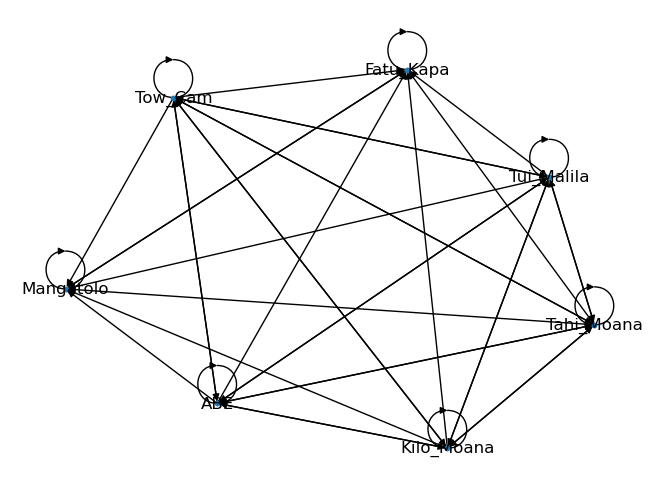

In [30]:
g = nx.DiGraph()
g.add_weighted_edges_from([tuple(x) for x in framex.values])
a_m = nx.to_numpy_array(g, weight = 'weight')
node_attr = vent_sites.set_index('name').to_dict('index')
nx.set_node_attributes(g, node_attr)
pos = nx.spring_layout(g, k=0.1)
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())

nx.draw(g,pos, node_size=10, with_labels =True)


/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/641030406.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, alpha=1)


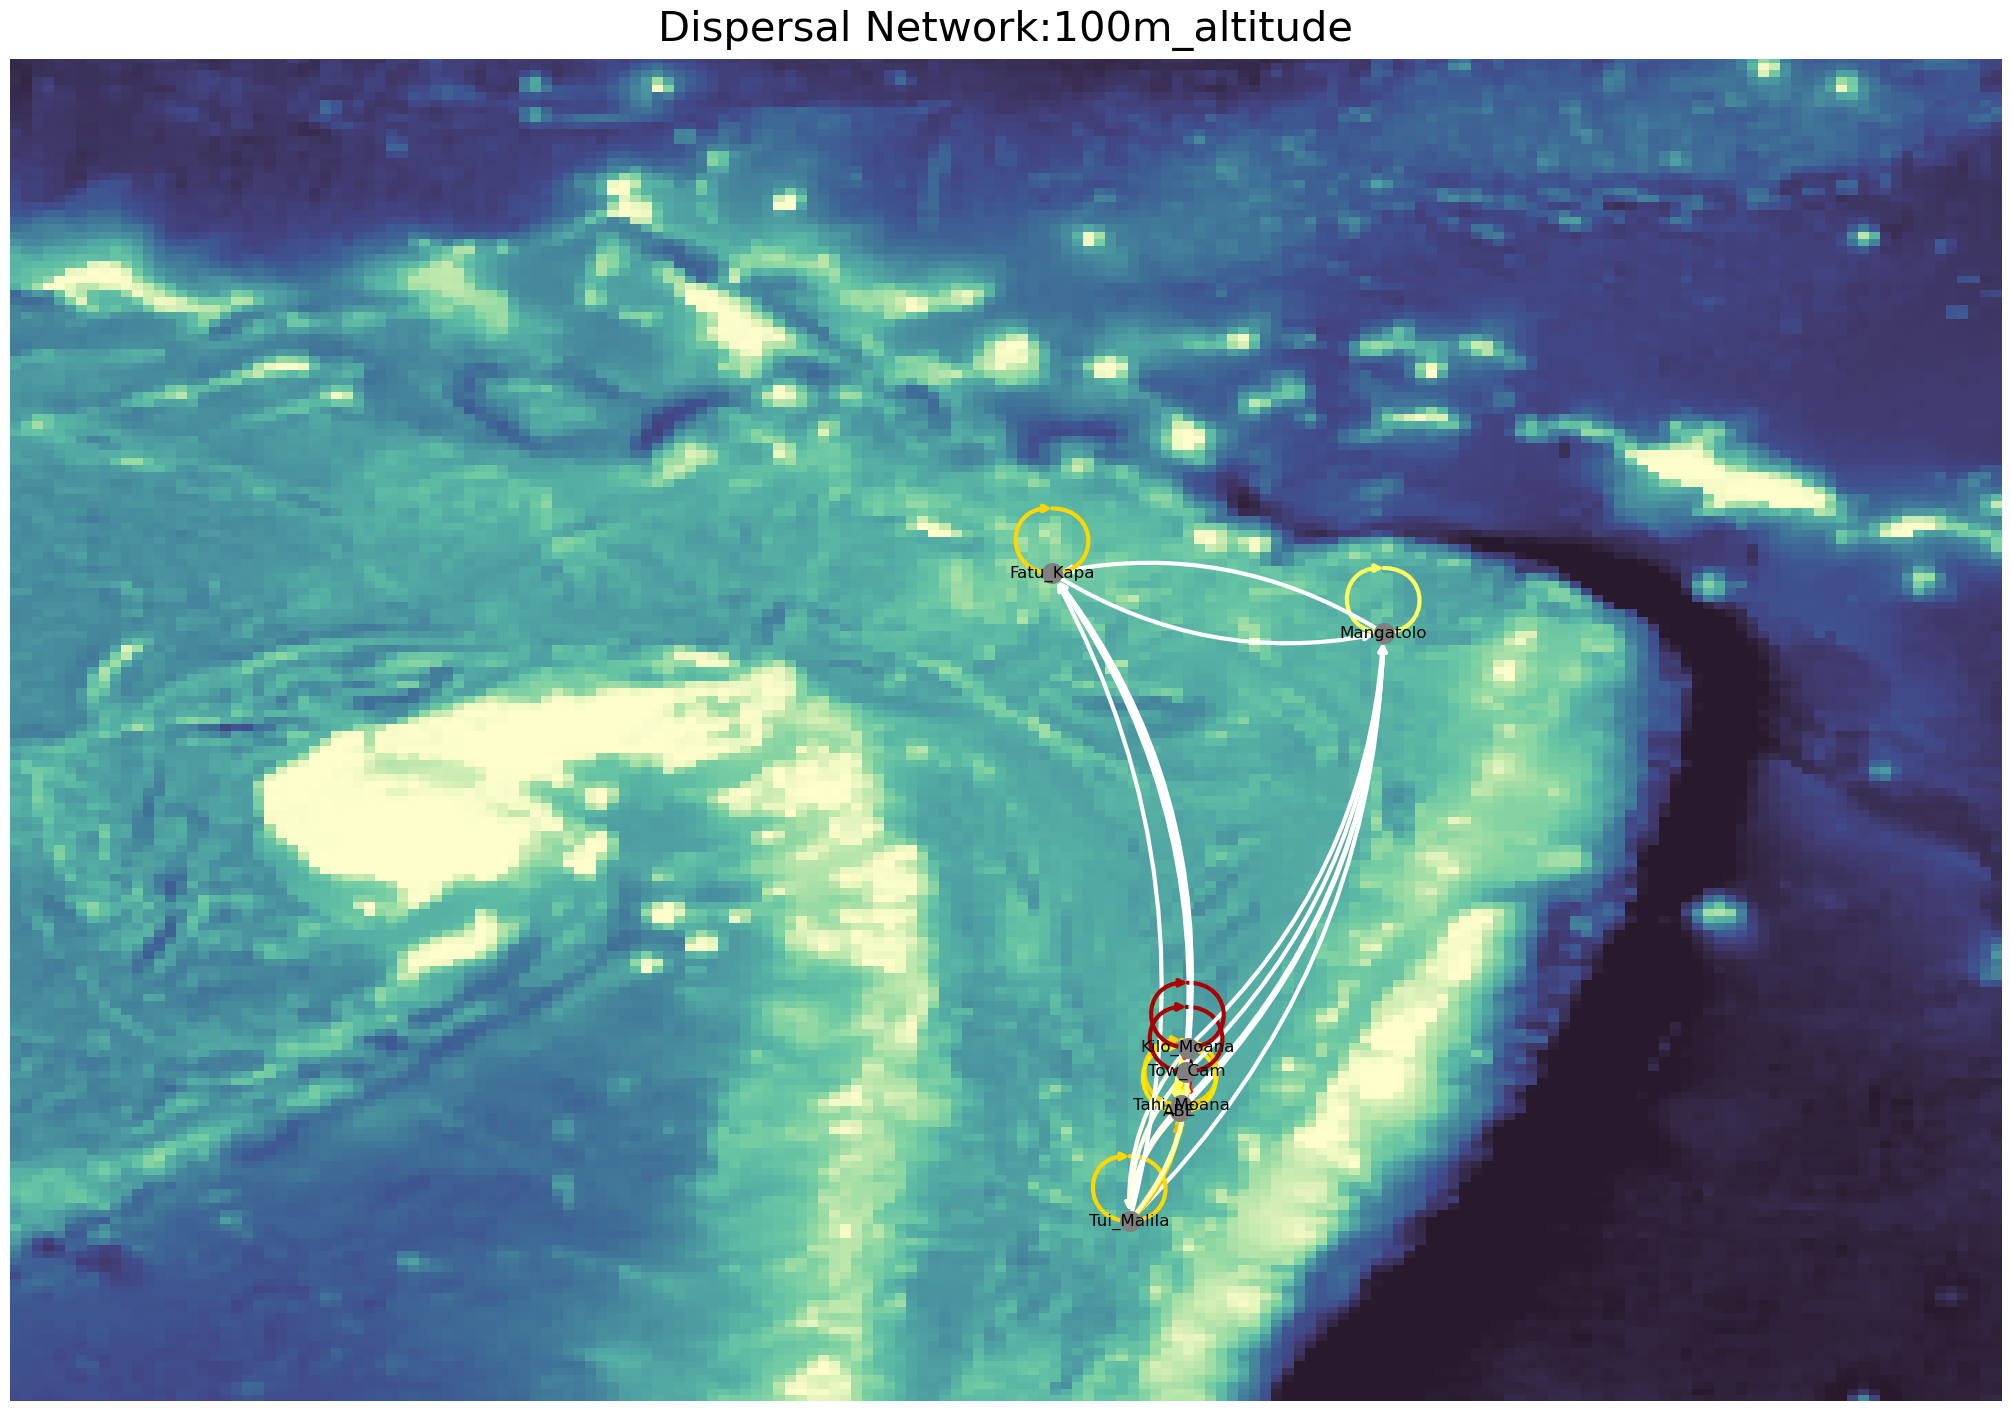

In [31]:
pos = {n : (g.nodes[n].get('lon')%360, g.nodes[n].get('lat')) for n in g.nodes()}

fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),constrained_layout=True)

fig.suptitle("Dispersal Network:"+depth+"_altitude", fontsize=30)

ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, alpha=1)

nx.draw(g,pos, 
        node_size=200, node_color = 'gray',
        edge_color=weights,edge_cmap=plt.cm.hot_r, width=3,
        connectionstyle="arc3,rad=0.2",
        with_labels =True)



ax.set_xlim(175, 190)
ax.set_ylim(-24, -9)


plt.savefig('figures/DN_int_'+run+'_'+depth)

plt.show()

### Apply a threshold that removes all incoming edgs that amount to <1% of total incoming edges (including self recruitment)

In [32]:

tg = g.copy()

for node in tg.nodes:
    
    #calculate total in.degree for each node
    tg.in_degree(node,weight='weight')
    #calculate 0.001 threshold for each site's total in-degree
    threshold = tg.in_degree(node,weight='weight')/1000

    #identify all incoming edges below the 0.001 threshold
    long_edges = list(filter(lambda e: e[2] < threshold, (e for e in tg.in_edges(node, data = 'weight'))))
    le_ids = list(e[:2] for e in long_edges)
    print(le_ids)

    # remove filtered edges from graph G
    tg.remove_edges_from(le_ids)
    
#Parameterize the edge weights again
tg_edges,tg_weights = zip(*nx.get_edge_attributes(tg,'weight').items())


[('Fatu_Kapa', 'Mangatolo'), ('Tahi_Moana', 'Mangatolo'), ('ABE', 'Mangatolo'), ('Tui_Malila', 'Mangatolo'), ('Tow_Cam', 'Mangatolo'), ('Kilo_Moana', 'Mangatolo')]
[('Mangatolo', 'Fatu_Kapa'), ('Tahi_Moana', 'Fatu_Kapa'), ('ABE', 'Fatu_Kapa'), ('Tui_Malila', 'Fatu_Kapa'), ('Tow_Cam', 'Fatu_Kapa'), ('Kilo_Moana', 'Fatu_Kapa')]
[]
[]
[]
[]
[]


/var/folders/5h/ggjcl6b11dvfn0m7gn06dngm0000gp/T/ipykernel_2269/2187862163.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, alpha=1)


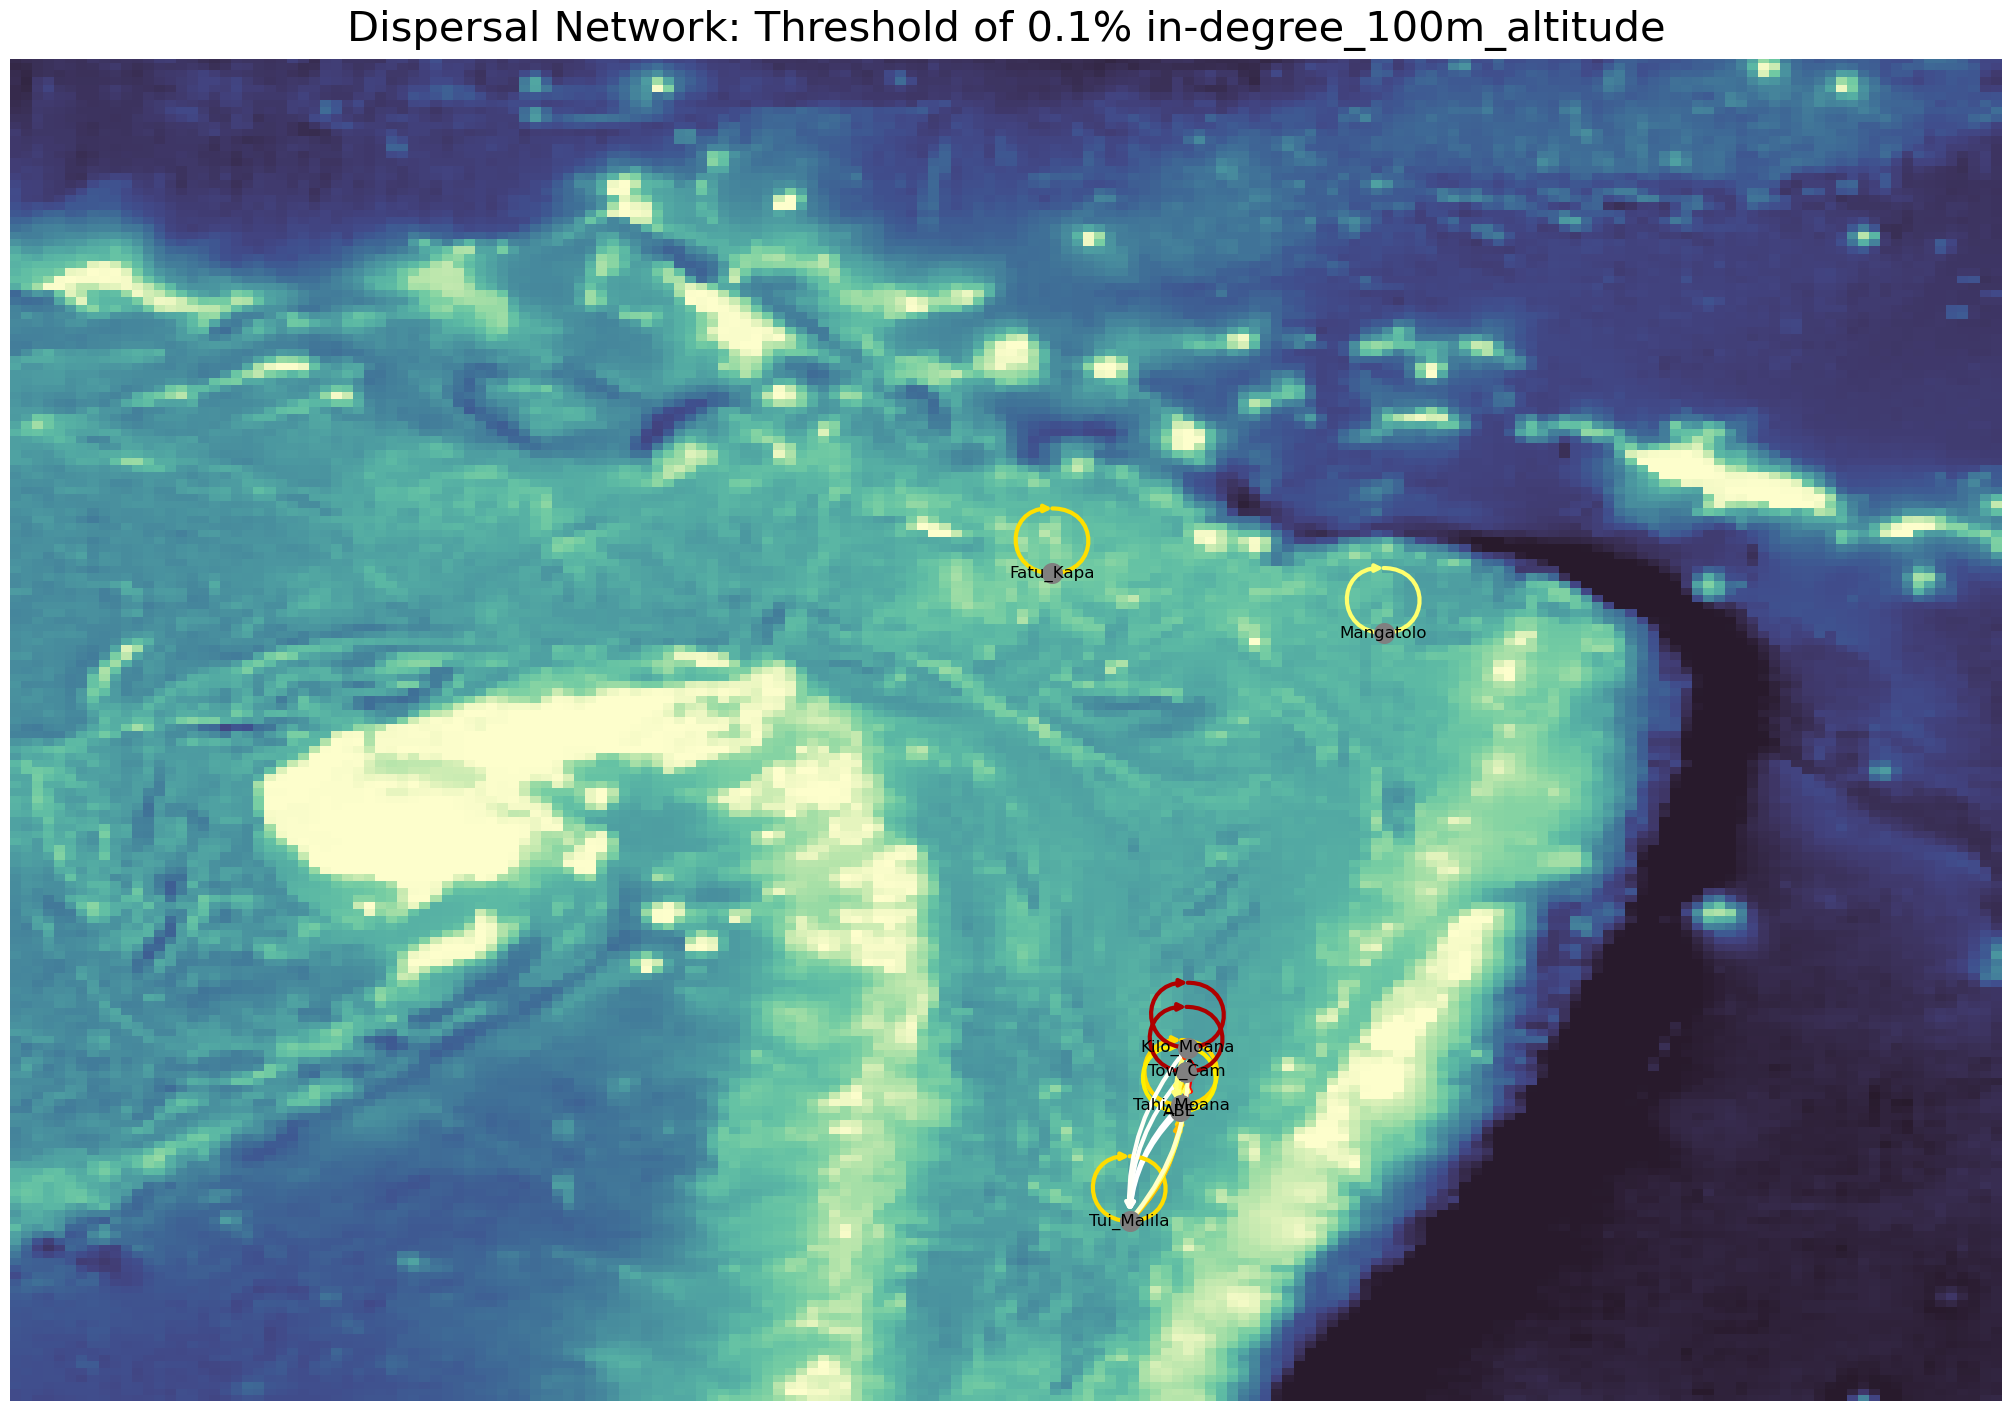

In [33]:
pos = {n : (tg.nodes[n].get('lon')%360, tg.nodes[n].get('lat')) for n in tg.nodes()}

fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),constrained_layout=True)

fig.suptitle("Dispersal Network: Threshold of 0.1% in-degree_"+depth+"_altitude", fontsize=30)

ax.pcolormesh(hgr['glamf'][0]%360,hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, alpha=1)

nx.draw(tg,pos, 
        node_size=200, node_color = 'gray',
        edge_color=tg_weights,edge_cmap=plt.cm.hot_r, width=3,
        connectionstyle="arc3,rad=0.2",
        with_labels =True)



ax.set_xlim(175, 190)
ax.set_ylim(-24, -9)


plt.savefig('figures/TN_int_'+run+'_'+depth)

plt.show()

In [34]:
#Export the matrix after threshold has been applied

# Create a DataFrame from tg_edges and tg_weights
df = pd.DataFrame({'Source': [u for u, _ in tg_edges],
                   'Target': [v for _, v in tg_edges],
                   'Weight': tg_weights})

# Pivot the DataFrame to create a matrix of pairwise weights
matrix = df.pivot(index='Source', columns='Target', values='Weight')

# Fill NaN values with 0
matrix = matrix.fillna(0)

matrix.to_csv('output/'+run+'_thresh_int_dispersalmatrix_'+depth+'.csv',)

matrix


Target,ABE,Fatu_Kapa,Kilo_Moana,Mangatolo,Tahi_Moana,Tow_Cam,Tui_Malila
Source,,,,,,,
ABE,2.574055e-07,0.000000e+00,5.866284e-07,0.000000e+00,3.005502e-07,5.469367e-07,1.427966e-08
Fatu_Kapa,0.000000e+00,2.807154e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Kilo_Moana,1.273384e-07,0.000000e+00,6.739328e-07,0.000000e+00,1.576546e-07,5.015191e-07,2.396751e-08
Mangatolo,0.000000e+00,0.000000e+00,0.000000e+00,1.429021e-07,0.000000e+00,0.000000e+00,0.000000e+00
Tahi_Moana,2.280983e-07,0.000000e+00,6.541973e-07,0.000000e+00,2.848946e-07,5.570343e-07,1.556823e-08
Tow_Cam,1.829415e-07,0.000000e+00,8.895929e-07,0.000000e+00,3.083072e-07,6.799030e-07,1.791454e-08
Tui_Malila,3.257232e-07,0.000000e+00,6.503088e-08,0.000000e+00,2.920704e-07,1.538154e-07,2.812827e-07
